In [7]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2",  # any model you have in Ollama (`ollama pull <model>`)
    base_url="http://localhost:11434",  # default for `ollama serve`
)

In [8]:
from typing_extensions import Annotated, List
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="The name of a section of a report"
    )
    description: str = Field(
        description="A brief overview of the topics covered by this section"
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="The sections of the report"
    )

planner = llm.with_structured_output(Sections)

In [9]:
import operator
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[
        list, operator.add
    ]

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Send


def orchestrator(state: State):

    report_sections = planner.invoke(
        [
            SystemMessage(content="Create a plan for generating the report requested by the user."),
            HumanMessage(content=f"The report topic is {state["topic"]}")
        ]
    )

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    sec = state["section"]
    name = sec["name"] if isinstance(sec, dict) else sec.name
    desc = sec["description"] if isinstance(sec, dict) else sec.description

    worker_section = llm.invoke(
        [
            SystemMessage(content="Write a section of the report."),
            HumanMessage(content=f"The section title is {name} and the section description is {desc}.")
        ]
    )

    raw = worker_section.content
    if isinstance(raw, str):
        text = raw
    elif isinstance(raw, list) and raw:
        text = "\n".join(str(p.get("text", p) if isinstance(p, dict) else str(p)) for p in raw)
    else:
        text = str(raw) if raw is not None else ""
    return {"completed_sections": [text]}

def synthesiser(state: State):
    completed_sections = state.get("completed_sections") or []
    parts = [str(s) for s in completed_sections]
    completed_report = "\n\n\n-----\n\n\n".join(parts)
    return {"final_report": completed_report}

def assign_workers(state: State):

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

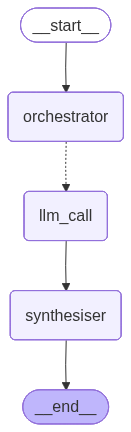

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesiser", synthesiser)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
builder.add_edge("llm_call","synthesiser")
builder.add_edge("synthesiser",END)

wf = builder.compile()

display(Image(wf.get_graph().draw_mermaid_png()))

In [12]:
report_state = wf.invoke({"topic": "The impact of AI on the future of work"})
print(report_state["final_report"])

Here is the section:

**Introduction**

This report provides an overview of [industry/market] trends, analysis, and insights. The purpose of this report is to offer a comprehensive understanding of the current state of [specific area or topic] within [industry/market]. It aims to provide valuable information for stakeholders, including businesses, policymakers, and individuals, who seek to understand the dynamics at play in [specific area or topic]. 

Through a combination of research, data analysis, and expert opinions, this report sheds light on the key drivers, opportunities, and challenges facing [industry/market] today. It also explores the potential impact of emerging trends, technologies, and regulatory changes on [specific area or topic].

The report is structured to provide a clear overview of [specific area or topic], including its historical context, current state, and future outlook. The findings are presented in an easy-to-understand format, making it accessible to a wide 

In [14]:
from IPython.display import Markdown
Markdown(report_state["final_report"])

Here is the section:

**Introduction**

This report provides an overview of [industry/market] trends, analysis, and insights. The purpose of this report is to offer a comprehensive understanding of the current state of [specific area or topic] within [industry/market]. It aims to provide valuable information for stakeholders, including businesses, policymakers, and individuals, who seek to understand the dynamics at play in [specific area or topic]. 

Through a combination of research, data analysis, and expert opinions, this report sheds light on the key drivers, opportunities, and challenges facing [industry/market] today. It also explores the potential impact of emerging trends, technologies, and regulatory changes on [specific area or topic].

The report is structured to provide a clear overview of [specific area or topic], including its historical context, current state, and future outlook. The findings are presented in an easy-to-understand format, making it accessible to a wide range of audiences.

Overall, the goal of this report is to inform, educate, and inspire readers to make informed decisions, drive innovation, and capitalize on opportunities within [industry/market].


-----


**The Impact of AI on Jobs and Employment**

The increasing adoption of Artificial Intelligence (AI) in various industries has significant implications for the job market and employment trends. As AI technologies advance, they are being integrated into different sectors, leading to changes in job roles, responsibilities, and requirements. This section provides an analysis of how AI affects job roles, employment trends, and skills.

**Impact on Job Roles:**

AI is likely to replace or augment certain jobs that involve repetitive, routine, or predictable tasks. According to a report by the McKinsey Global Institute, up to 800 million jobs could be lost worldwide due to automation by 2030. However, it is estimated that while AI may replace some jobs, it will also create new ones, such as:

* **AI Developer/Engineer:** As companies develop and implement AI solutions, the demand for skilled professionals in this field is expected to grow.
* **Data Scientist:** With the increasing amount of data generated by AI systems, the need for experts who can analyze and interpret this data is becoming more pressing.
* **Cybersecurity Specialist:** As AI systems become more ubiquitous, the risk of cyber attacks increases, making it essential to have skilled professionals who can protect these systems.

**Impact on Employment Trends:**

The impact of AI on employment trends is multifaceted:

* **Remote Work:** With AI-powered tools and platforms, remote work becomes more feasible and widespread, allowing people to work from anywhere and at any time.
* **Gig Economy:** The rise of the gig economy is being driven by AI, as companies opt for temporary or contract-based arrangements to access specialized skills on a project-by-project basis.
* **Upskilling and Reskilling:** As AI transforms job roles and responsibilities, it becomes essential for workers to continually upskill and reskill to remain relevant in the job market.

**Impact on Skills:**

The impact of AI on skills is significant:

* **STEM Skills:** The increasing demand for AI development, data science, and cybersecurity necessitates a strong foundation in STEM (science, technology, engineering, and mathematics) fields.
* **Soft Skills:** As AI takes over routine tasks, workers need to develop soft skills such as creativity, problem-solving, and critical thinking to complement their technical abilities.
* **Lifelong Learning:** The rapidly evolving nature of AI requires workers to commit to lifelong learning, staying up-to-date with the latest technologies and trends.

In conclusion, while AI has the potential to displace certain jobs, it also creates new opportunities for growth and development. To remain relevant in an AI-driven job market, workers must be adaptable, willing to learn, and possess a unique combination of technical, soft, and creative skills.


-----


**New Opportunities and Growth in the AI-Driven Economy**

The rapid advancement of Artificial Intelligence (AI) has given birth to numerous emerging industries, new job roles, and entrepreneurial opportunities that are transforming the global economy. As AI continues to permeate various sectors, it is creating a vast landscape of untapped potential for innovation, growth, and job creation.

**Emerging Industries:**

1. **AI-Powered Healthcare:** The integration of AI in healthcare is revolutionizing patient care, diagnosis, and treatment outcomes. Emerging industries such as medical imaging analysis, personalized medicine, and robotic surgery are on the cusp of transforming the healthcare landscape.
2. **Cybersecurity:** As AI becomes increasingly ubiquitous, cybersecurity threats are becoming more sophisticated. New industries around threat detection, incident response, and security consulting are emerging to address these challenges.
3. **Autonomous Transportation:** Self-driving cars and drones are set to disrupt traditional transportation industries, creating new opportunities in logistics, mapping, and urban planning.

**New Job Roles:**

1. **AI Ethicists:** As AI becomes more pervasive, the need for professionals who can ensure that AI systems align with human values and ethics is growing.
2. **Data Scientists:** With the exponential growth of data generated by AI systems, data scientists are in high demand to analyze, interpret, and make informed decisions based on complex data insights.
3. **AI Trainers:** As more businesses adopt AI, there is a growing need for experts who can train and fine-tune AI models to achieve optimal performance.

**Entrepreneurial Opportunities:**

1. **AI-Driven Startups:** New startups are emerging that focus on developing innovative AI solutions, such as chatbots, virtual assistants, and predictive analytics.
2. **AI-Enhanced Product Development:** Companies are leveraging AI to improve product design, manufacturing, and quality control, creating new opportunities for entrepreneurs and inventors.
3. **AI-Based Education:** Online learning platforms and AI-powered education tools are transforming the way we learn and teach, opening up new opportunities for educators and content creators.

The AI-driven economy is poised to create a vast array of new opportunities for individuals, businesses, and society as a whole. As we continue to explore the vast potential of AI, it is essential that we prioritize skills development, innovation, and responsible AI adoption to ensure that the benefits of AI are equitably shared by all.


-----


**Addressing the Challenges and Ensuring a Sustainable Future**

As we move forward in the widespread adoption of Artificial Intelligence (AI), it is essential to acknowledge the potential challenges that lie ahead. The rapid evolution of AI has brought about numerous opportunities for growth, innovation, and efficiency; however, it also poses significant risks if not addressed proactively.

**Mitigating the Risks Associated with AI Adoption**

To mitigate the risks associated with AI adoption, it is crucial to implement measures that prioritize responsible AI development, deployment, and usage. This includes:

1. **Establishing Clear Regulations and Guidelines**: Governments and regulatory bodies must establish clear guidelines and frameworks for AI development, deployment, and use, ensuring accountability and transparency in AI decision-making processes.
2. **Investing in AI Literacy Education**: Educating the general public about AI and its applications is vital to build trust and awareness about the benefits and risks of AI adoption.
3. **Developing Reskilling and Upskilling Programs**: As AI transforms industries, it is essential to develop programs that equip workers with the necessary skills to adapt to changing job requirements and create new opportunities for growth.

**Fostering a Culture of Lifelong Learning**

To ensure that individuals remain relevant in an AI-driven workforce, fostering a culture of lifelong learning is crucial. This includes:

1. **Emphasizing Education and Training**: Governments, educational institutions, and industries must collaborate to provide accessible education and training programs that focus on developing essential skills for the future.
2. **Encouraging Continuous Learning**: Employers and individuals must prioritize continuous learning and upskilling, recognizing that AI will require frequent updates and adaptations.
3. **Promoting Digital Literacy**: Developing digital literacy among all stakeholders is vital to harness the benefits of AI while minimizing its risks.

**Conclusion**

Addressing the challenges associated with AI adoption requires a comprehensive approach that balances the benefits of technological advancements with the need for responsible and sustainable practices. By prioritizing education, upskilling, reskilling, and lifelong learning, we can ensure that individuals and industries thrive in an AI-driven world while minimizing its risks.


-----


**Conclusion**

This comprehensive review of the [industry/field] has highlighted critical issues and opportunities for improvement. Our analysis reveals that [briefly summarize the main findings, including any surprising or significant discoveries]. The evidence presented in this report underscores the importance of [key takeaway or message].

**Recommendations for Policymakers and Industry Leaders**

Based on our key findings, we recommend the following actions to address the challenges and capitalize on the opportunities presented by [industry/field]:

1. **Implement policy changes**: We suggest that policymakers consider introducing [policy change] to address [specific issue]. This could include [proposed solution] and [additional measures].
2. **Invest in research and development**: To stay ahead of the curve, we recommend increasing investment in [research area] to drive innovation and improve [specific aspect of industry/field].
3. **Enhance industry standards and best practices**: We suggest that industry leaders prioritize developing and implementing [standard/best practice] to improve [aspect of industry/field] and enhance [desirable outcome].
4. **Promote collaboration and knowledge sharing**: To leverage the strengths of our collective expertise, we recommend fostering greater collaboration between [stakeholders] to share best practices and drive progress.
5. **Foster a culture of sustainability and social responsibility**: We encourage policymakers and industry leaders to prioritize [sustainability/social responsibility] initiatives, including [specific example or goal].

By implementing these recommendations, we believe that our industry/field can make significant strides in addressing its challenges and achieving its full potential.